In [1]:
import os, ast, math, json
import numpy as np
import pandas as pd
import torch
from tqdm.auto import tqdm
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import joblib
import matplotlib.pyplot as plt

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE


/home/federicostachurski/epc-nlp-project/.npl_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'cuda'

In [4]:
# CELL 2 — paths (edit if you saved elsewhere)
MODEL_DIR = "../models/epc_distilbert_multilabel/best"
MLB_PATH  = "../models/mlb.joblib"
DATA_PATH = "../data/processed/epc_property_level.csv"  # prefer parquet; else use CSV + converters

# load model, tokenizer, binarizer
tok   = AutoTokenizer.from_pretrained(MODEL_DIR)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_DIR).to(DEVICE).eval()
mlb   = joblib.load(MLB_PATH)
mlb.classes_.tolist()


['glazing', 'heating', 'hot_water', 'insulation', 'lighting', 'renewables']

In [5]:
# CELL 3 — read data (parquet first; fallback to CSV if needed)

prop_df = pd.read_csv(
    DATA_PATH,
    converters={
        "labels":  lambda s: ast.literal_eval(s) if pd.notna(s) else [],
        "periods": lambda s: ast.literal_eval(s) if pd.notna(s) else [],
    },
)

# Minimal columns we’ll use
cols = [c for c in ["rrn","text_clean","labels","periods"] if c in prop_df.columns]
prop_df = prop_df[cols].rename(columns={"text_clean":"text"})
len(prop_df), prop_df.head(2)


(885536,
                         rrn  \
 0  0120-2329-6030-9075-1045   
 1  1315-5023-2000-0479-0902   
 
                                                 text  \
 0  solar photovoltaic panels kwp replace boiler n...   
 1  room roof insulation internal external wall in...   
 
                                               labels   periods  
 0        [heating, insulation, lighting, renewables]  [2015Q3]  
 1  [glazing, heating, insulation, lighting, renew...  [2015Q3]  )

In [22]:
# CELL 4 — batched predictor returning a tidy DataFrame
def select_labels(probs, labels, min_k=1, max_k=3, min_prob=0.05):
    """
    probs: 1D array of probabilities (floats)
    labels: list of class names
    min_k: always predict at least this many
    max_k: never predict more than this many
    min_prob: discard labels below this probability
    """
    # Sort by probability
    ranked = sorted(zip(labels, probs), key=lambda x: x[1], reverse=True)

    # Apply probability floor
    filtered = [(lbl, p) for lbl, p in ranked if p >= min_prob]

    # Take up to max_k (but ensure at least min_k)
    top = filtered[:max_k] if filtered else ranked[:min_k]

    return [lbl for lbl, _ in top]


@torch.no_grad()
def predict_df(texts, batch_size=64):
    # normalize to list[str]
    if isinstance(texts, pd.Series): texts = texts.astype(str).tolist()
    elif isinstance(texts, np.ndarray): texts = texts.astype(str).tolist()
    elif isinstance(texts, str): texts = [texts]
    else: texts = [str(t) for t in texts]

    results = []
    for i in tqdm(range(0, len(texts), batch_size)):
        batch = texts[i:i+batch_size]
        enc = tok(batch, truncation=True, padding=True, return_tensors="pt").to(DEVICE)
        logits = model(**enc).logits
        probs = torch.sigmoid(logits).cpu().numpy()  # (B, n_labels)
        for txt, p in zip(batch, probs):
            results.append({
                "text": txt,
                **{f"p_{lbl}": float(v) for lbl, v in zip(mlb.classes_, p)}, "prediction": select_labels(p, mlb.classes_, min_k=1, max_k=4, min_prob=0.0005)})

    return pd.DataFrame(results)


In [23]:
samples = [
    "Install double glazing on all windows.",
    "Upgrade the high-efficiency condensing boiler with smart thermostatic controls.",
    "Replace the hot water cylinder and insulate all pipes.",
    "Fit low-energy LED lighting for all fixed outlets.",
    "Add loft and cavity wall insulation and consider cavity fill.",
    "Add solar PV panels and heat pump to reduce electricity demand.",
    # all-in-one:
    "Double glazing, loft and cavity insulation, condensing boiler, new hot water cylinder, LED lighting, and solar panels."
]
pred_samples = predict_df(samples, batch_size=8)
pred_samples

100%|██████████| 1/1 [00:00<00:00, 10.24it/s]


,text,p_glazing,p_heating,p_hot_water,p_insulation,p_lighting,p_renewables,prediction
0,Install double glazing on all windows.,0.168939,0.000636,0.000001,2.310894e-03,4.735593e-07,6.167273e-04,"[glazing, insulation, heating, renewables]"
1,Upgrade the high-efficiency condensing boiler ...,0.000050,0.999989,0.000157,1.680303e-05,2.303683e-05,1.337248e-04,[heating]
2,Replace the hot water cylinder and insulate al...,0.003872,0.087681,0.999915,9.999896e-01,3.438103e-05,5.975659e-06,"[insulation, hot_water, heating, glazing]"
3,Fit low-energy LED lighting for all fixed outl...,0.000445,0.000013,0.000039,9.941889e-06,9.999920e-01,3.368242e-05,[lighting]
4,Add loft and cavity wall insulation and consid...,0.000039,0.000213,0.000029,9.999964e-01,5.046066e-06,8.305492e-07,[insulation]
5,Add solar PV panels and heat pump to reduce el...,0.000013,0.001211,0.000002,7.564019e-07,4.702834e-05,9.999827e-01,"[renewables, heating]"
6,"Double glazing, loft and cavity insulation, co...",0.000214,0.999997,0.999982,9.999895e-01,2.678163e-03,9.999734e-01,"[heating, insulation, hot_water, renewables]"


In [100]:
N = min(len(prop_df), 100_000)   # bump later if memory allows
subset = prop_df.sample(n=N, random_state=42) if len(prop_df) > N else prop_df.copy()

pred_2022 = predict_df(subset["text"], batch_size=64)
pred_2022.insert(0, "rrn", subset["rrn"].values if "rrn" in subset.columns else np.arange(len(subset)))
if "periods" in subset.columns: pred_2022["periods"] = subset["periods"].values
if "labels"  in subset.columns: pred_2022["labels_true"] = subset["labels"].values

os.makedirs("../data/predictions", exist_ok=True)
OUT_PATH = f"../data/predictions/preds_{N}_<2022.csv"
pred_2022.to_csv(OUT_PATH, index=False)
OUT_PATH

100%|██████████| 1563/1563 [01:17<00:00, 20.10it/s]


'../data/predictions/preds_100000_<2022.csv'

In [69]:
label_cols = [c for c in pred_2022.columns if c.startswith("p_")]
exp_counts = pred_2022[label_cols].sum(0).rename(lambda c: c.replace("p_","")).sort_values(ascending=False)
np.round(exp_counts)

insulation    35968.0
renewables    30245.0
lighting      25012.0
heating       18785.0
glazing        7307.0
hot_water      5654.0
dtype: float64

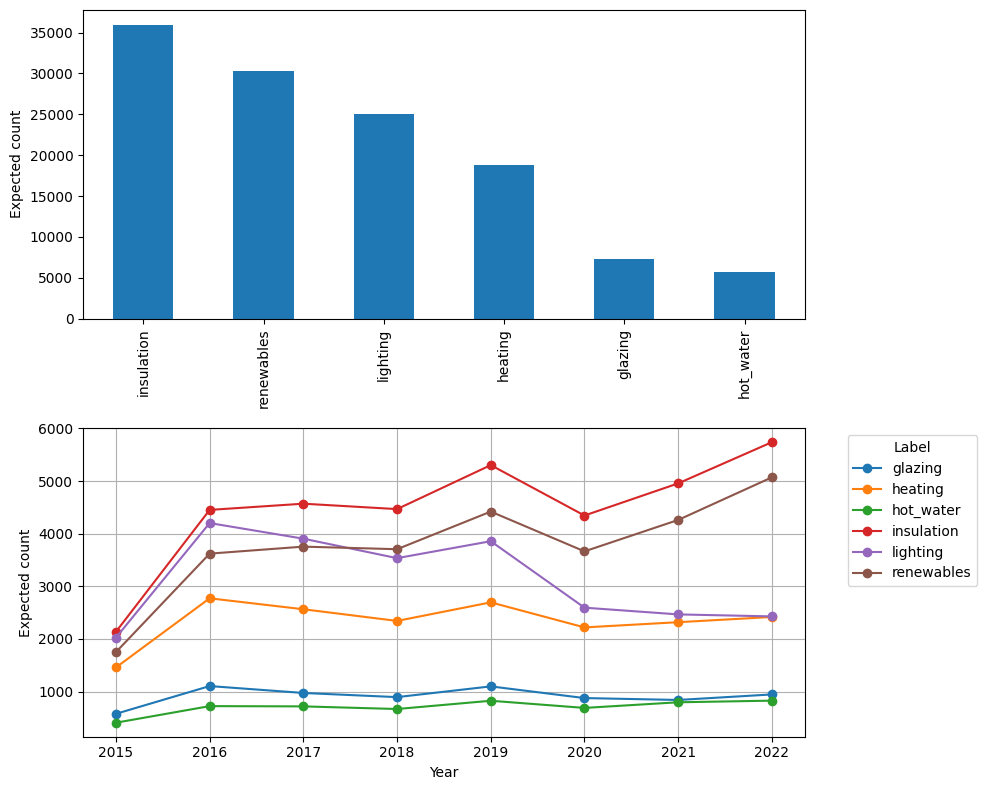

In [ ]:
import matplotlib.pyplot as plt

# --- top-level expected counts ---
exp_counts = pred_2022[label_cols].sum(0).rename(lambda c: c.replace("p_","")).sort_values(ascending=False)

# --- group per year ---
if "periods" in pred_2022.columns:
    tmp = pred_2022.explode("periods").copy()
    tmp = tmp[tmp["periods"].notna()]
    tmp["year"] = tmp["periods"].str.slice(0,4)

    grp = tmp.groupby("year")[label_cols].sum().rename(columns=lambda c: c.replace("p_",""))

    # --- make figure with 2 subplots ---
    fig, axes = plt.subplots(2, 1, figsize=(10,8), sharex=False)

    # Top row: bar chart of totals
    exp_counts.plot(kind="bar", ax=axes[0])
    # axes[0].set_title("Total expected count per label")
    axes[0].set_ylabel("Expected count")

    # Bottom row: all lines in one plot
    grp.sort_index().plot(ax=axes[1], marker="o")
    # axes[1].set_title("Expected count over time (all labels)")
    axes[1].set_ylabel("Expected count")
    axes[1].set_xlabel("Year")
    axes[1].legend(title="Label", bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()


In [ ]:
# # A_build_inference_texts_2023p.py
# import os, re, glob, sys, gc
# import pandas as pd
# from collections import defaultdict

# # so we can import your project utils
# sys.path.insert(0, os.path.abspath(".."))
# from src.preprocess import split_improvements, parse_improvement, clean_text

# DATA_GLOB  = "../data/raw/D_EPC_data_*/*.csv"
# OUT_PATH   = "../data/processed/inference_texts_2023p.csv"
# ID_COL, TEXT_COL = "REPORT_REFERENCE_NUMBER", "IMPROVEMENTS"
# CHUNKSIZE  = 10_000

# period_re = re.compile(r"(?<!\d)(\d{4})Q([1-4])(?!\d)")
# def period_from_path(p):
#     fn = os.path.basename(p)
#     m = period_re.search(fn)
#     if m: return m.group(0)
#     ms = list(period_re.finditer(p))
#     return ms[-1].group(0) if ms else "UNKNOWN"

# # 1) discover only 2023+ files
# targets = []
# for f in sorted(glob.glob(DATA_GLOB)):
#     per = period_from_path(f)
#     if per and per != "UNKNOWN" and int(per[:4]) >= 2023:
#         targets.append((f, per))

# if not targets:
#     raise RuntimeError("No 2023+ CSVs found. Check filenames or DATA_GLOB.")

# rows = []
# for fpath, period in targets:
#     print("Reading:", fpath, "(period:", period, ")")
#     reader = pd.read_csv(fpath, chunksize=CHUNKSIZE, low_memory=False, usecols=[ID_COL, TEXT_COL])
#     # aggregate per RRN within this file (period)
#     per_texts = defaultdict(list)

#     for chunk in reader:
#         for rrn, txt in chunk[[ID_COL, TEXT_COL]].itertuples(index=False, name=None):
#             if not isinstance(txt, str): 
#                 continue
#             for seg in split_improvements(txt):
#                 rec = parse_improvement(seg) or {}
#                 m = rec.get("measure") or seg   # fallback to raw segment
#                 per_texts[rrn].append(m)
#         del chunk; gc.collect()

#     # emit rows (one per RRN×period)
#     for rrn, measures in per_texts.items():
#         text_raw = " . ".join(measures)
#         text_cleaned = clean_text(text_raw)
#         rows.append({"rrn": rrn, "period": period, "text": text_cleaned})

# # collapse duplicates across files (if any)
# df = pd.DataFrame(rows)
# if df.empty:
#     raise RuntimeError("No rows built for 2023+. Are columns correct?")

# df = (df.groupby(["rrn","period"], as_index=False)
#         .agg(text=("text", "first")))  # keep first; texts are already concatenated

# os.makedirs(os.path.dirname(OUT_PATH), exist_ok=True)
# df.to_csv(OUT_PATH, index=False)
# print(f"Saved {len(df):,} rows → {OUT_PATH}")


Reading: ../data/raw/D_EPC_data_2025Q2/2023Q1.csv (period: 2023Q1 )
Reading: ../data/raw/D_EPC_data_2025Q2/2023Q2.csv (period: 2023Q2 )
Reading: ../data/raw/D_EPC_data_2025Q2/2023Q3.csv (period: 2023Q3 )
Reading: ../data/raw/D_EPC_data_2025Q2/2023Q4.csv (period: 2023Q4 )
Reading: ../data/raw/D_EPC_data_2025Q2/2024Q1.csv (period: 2024Q1 )
Reading: ../data/raw/D_EPC_data_2025Q2/2024Q2.csv (period: 2024Q2 )
Reading: ../data/raw/D_EPC_data_2025Q2/2024Q3.csv (period: 2024Q3 )
Reading: ../data/raw/D_EPC_data_2025Q2/2024Q4.csv (period: 2024Q4 )
Reading: ../data/raw/D_EPC_data_2025Q2/2025Q1.csv (period: 2025Q1 )
Reading: ../data/raw/D_EPC_data_2025Q2/2025Q2.csv (period: 2025Q2 )
Saved 403,095 rows → ../data/processed/inference_texts_2023p.csv


In [46]:
# B_infer_2023p.py
import os, numpy as np, pandas as pd, torch, joblib
from transformers import AutoTokenizer, AutoModelForSequenceClassification

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

MODEL_DIR = "../models/epc_distilbert_multilabel/best"
MLB_PATH  = "../models/mlb.joblib"
DATA_PATH = "../data/processed/inference_texts_2023p.csv"

tok   = AutoTokenizer.from_pretrained(MODEL_DIR)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_DIR).to(DEVICE).eval()
mlb   = joblib.load(MLB_PATH)
classes = mlb.classes_.tolist()
label_cols = [f"p_{c}" for c in classes]

def select_labels(probs, labels, min_k=1, max_k=3, min_prob=0.05):
    ranked = sorted(zip(labels, probs), key=lambda x: x[1], reverse=True)
    filtered = [(lbl, p) for lbl, p in ranked if p >= min_prob]
    top = filtered[:max_k] if filtered else ranked[:min_k]
    return [lbl for lbl, _ in top]

@torch.no_grad()
def predict_over_texts(texts, batch_size=64, min_k=1, max_k=3, min_prob=0.05):
    # normalize list[str]
    if isinstance(texts, pd.Series): texts = texts.astype(str).tolist()
    elif isinstance(texts, np.ndarray): texts = texts.astype(str).tolist()
    elif isinstance(texts, str): texts = [texts]
    else: texts = [str(t) for t in texts]

    rows = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        enc = tok(batch, truncation=True, padding=True, return_tensors="pt").to(DEVICE)
        probs = torch.sigmoid(model(**enc).logits).cpu().numpy()
        for txt, p in zip(batch, probs):
            rows.append({
                "text": txt,
                "prediction": select_labels(p, classes, min_k=min_k, max_k=max_k, min_prob=min_prob),
                **{f"p_{lbl}": float(val) for lbl, val in zip(classes, p)}
            })
    return pd.DataFrame(rows)

# Load 2023+ text rows
inf_df = pd.read_csv(DATA_PATH)

# Run inference in chunks to keep memory predictable
parts = []
BLOCK = 10000  # adjust to your RAM
for start in tqdm(range(0, len(inf_df), BLOCK), desc="Predicting >2023Q + 2024Q + ..."):
    part = inf_df.iloc[start:start+BLOCK]
    pred = predict_over_texts(part["text"], batch_size=64, min_k=1, max_k=3, min_prob=0.05)
    pred.insert(0, "rrn", part["rrn"].values)
    pred.insert(1, "period", part["period"].values)
    parts.append(pred)

pred_2023p = pd.concat(parts, ignore_index=True)
os.makedirs("../data/predictions", exist_ok=True)
OUT = "../data/predictions/preds_2023p.csv"
pred_2023p.to_csv(OUT, index=False)
print(f"Saved predictions → {OUT}\nRows: {len(pred_2023p):,}")
pred_2023p.head(3)


Predicting >2023Q + 2024Q + ...: 100%|██████████| 41/41 [05:37<00:00,  8.22s/it]


Saved predictions → ../data/predictions/preds_2023p.csv
Rows: 403,095


,rrn,period,text,prediction,p_glazing,p_heating,p_hot_water,p_insulation,p_lighting,p_renewables
0,0000-0019-0622-3296-1743,2024Q1,internal external wall insulation floor insula...,"[insulation, glazing]",0.999967,0.000027,0.000017,0.999972,0.000019,0.000019
1,0000-0023-0922-2199-1143,2024Q3,increase loft insulation mm cavity wall insula...,"[insulation, renewables]",0.000004,0.000004,0.000003,0.999993,0.000003,0.999993
2,0000-0120-0922-3004-1773,2023Q1,solar photovoltaic panels kwp,[renewables],0.000006,0.000007,0.000004,0.000007,0.000007,0.999993


In [79]:
pred_2023p

,rrn,period,text,prediction,p_glazing,p_heating,p_hot_water,p_insulation,p_lighting,p_renewables
0,0000-0019-0622-3296-1743,2024Q1,internal external wall insulation floor insula...,"[insulation, glazing]",0.999967,0.000027,0.000017,0.999972,0.000019,0.000019
1,0000-0023-0922-2199-1143,2024Q3,increase loft insulation mm cavity wall insula...,"[insulation, renewables]",0.000004,0.000004,0.000003,0.999993,0.000003,0.999993
2,0000-0120-0922-3004-1773,2023Q1,solar photovoltaic panels kwp,[renewables],0.000006,0.000007,0.000004,0.000007,0.000007,0.999993
3,0000-0125-0122-1003-1673,2023Q2,internal external wall insulation replacement ...,"[insulation, glazing]",0.999968,0.000026,0.000017,0.999982,0.000023,0.000023
4,0000-0136-0722-6195-1273,2023Q1,solar water heating solar photovoltaic panels ...,"[insulation, renewables]",0.000005,0.000005,0.000002,0.999995,0.000004,0.999994
...,...,...,...,...,...,...,...,...,...,...
403080,9997-1924-9200-8017-2204,2023Q4,floor insulation suspended floor,[insulation],0.000007,0.000009,0.000007,0.999992,0.000008,0.000007
403081,9998-1965-0332-1954-1224,2024Q4,solar water heating,[renewables],0.000006,0.000006,0.000003,0.000008,0.000007,0.999993
403082,9999-1011-9201-2907-6200,2023Q3,replace boiler new condensing boiler internal ...,"[lighting, insulation, heating]",0.999961,0.999964,0.000036,0.999976,0.999985,0.000023
403083,9999-1012-3209-2867-5200,2023Q1,cavity wall insulation,[insulation],0.000008,0.000009,0.000008,0.999992,0.000008,0.000007


In [101]:
pred_2022 = pred_2022.rename(columns={"periods": "period"}) if "periods" in pred_2022.columns else None
pred_2022["period"] = pred_2022["period"].str[0]


In [109]:
import re

RRN_RE = re.compile(r"^\d{4}-\d{4}-\d{4}-\d{4}-\d{4}$")


def is_bad_row(df):
    bad_rrn  = ~df["rrn"].astype(str).str.match(RRN_RE)
    bad_text = df["text"].astype(str).str.strip().str.lower().isin({
        "improvement", "improvements", "measure", "measures", "text"
    })
    too_short = df["text"].astype(str).str.len().lt(10)  # tweak if you want
    return bad_rrn | bad_text | too_short

# Apply to each predictions frame, then recompute plots
pred_2022   = pred_2022.loc[~is_bad_row(pred_2022)].reset_index(drop=True)
pred_2023p = pred_2023p.sample(n = 30000, random_state = 42).loc[~is_bad_row(pred_2023p)].reset_index(drop=True)

# Ensure both have consistent columns
common_cols = [c for c in pred_2022.columns if c in pred_2023p.columns]

pred_both = pd.concat([pred_2022[common_cols], pred_2023p[common_cols]], ignore_index=True)

# sanity check
pred_both.head(3), len(pred_both)


(                        rrn  \
 0  9190-2545-0100-2509-2595   
 1  8312-2922-9109-0051-0292   
 2  5190-2553-0729-1100-1083   
 
                                                 text  p_glazing  p_heating  \
 0  increase loft insulation mm low energy lightin...   0.000008   0.000009   
 1  solar water heating wind turbine room roof ins...   0.999947   0.000025   
 2                   floor insulation suspended floor   0.000007   0.000009   
 
    p_hot_water  p_insulation  p_lighting  p_renewables  \
 0     0.000005      0.999992    0.999988      0.000005   
 1     0.000012      0.999973    0.000013      0.999962   
 2     0.000007      0.999992    0.000008      0.000007   
 
                           prediction  period  
 0             [insulation, lighting]  2021Q4  
 1  [insulation, renewables, glazing]  2022Q4  
 2                       [insulation]  2018Q4  ,
 130000)

In [110]:
pred_both

,rrn,text,p_glazing,p_heating,p_hot_water,p_insulation,p_lighting,p_renewables,prediction,period
0,9190-2545-0100-2509-2595,increase loft insulation mm low energy lightin...,0.000008,0.000009,0.000005,0.999992,0.999988,0.000005,"[insulation, lighting]",2021Q4
1,8312-2922-9109-0051-0292,solar water heating wind turbine room roof ins...,0.999947,0.000025,0.000012,0.999973,0.000013,0.999962,"[insulation, renewables, glazing]",2022Q4
2,5190-2553-0729-1100-1083,floor insulation suspended floor,0.000007,0.000009,0.000007,0.999992,0.000008,0.000007,[insulation],2018Q4
3,0292-2672-3039-3527-1983,solar photovoltaic panels kwp solar water heating,0.000005,0.000007,0.000004,0.000008,0.000006,0.999993,[renewables],2018Q4
4,9682-1004-2208-3185-9900,internal external wall insulation replace boil...,0.000013,0.999973,0.000016,0.999983,0.000012,0.000017,"[insulation, heating]",2015Q3
...,...,...,...,...,...,...,...,...,...,...
129995,1415-9127-2100-0554-6206,cavity wall insulation floor insulation suspen...,0.000011,0.999990,0.000013,0.999983,0.000009,0.999988,"[heating, renewables, insulation]",2025Q1
129996,6117-7929-4000-0136-5292,floor insulation suspended floor,0.000007,0.000009,0.000007,0.999992,0.000008,0.000007,[insulation],2023Q1
129997,9650-1047-0237-4407-4224,floor insulation suspended floor solar water h...,0.000005,0.000005,0.000003,0.999994,0.000004,0.999995,"[renewables, insulation]",2023Q1
129998,3517-4125-8100-0370-9272,floor insulation suspended floor solar photovo...,0.000009,0.999987,0.000007,0.999992,0.999995,0.999994,"[lighting, renewables, insulation]",2023Q2


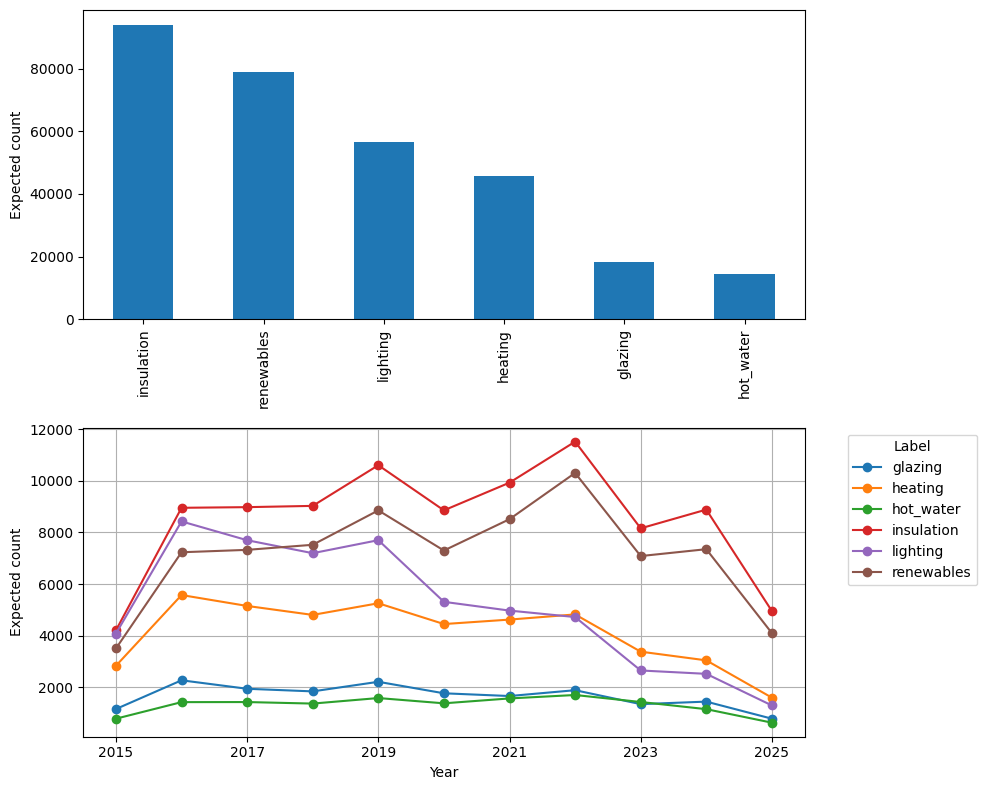

In [111]:
import matplotlib.pyplot as plt

# --- top-level expected counts ---
exp_counts = pred_both[label_cols].sum(0).rename(lambda c: c.replace("p_","")).sort_values(ascending=False)

# --- group per year ---
if "period" in pred_both.columns:
    tmp = pred_both.explode("period").copy()
    tmp = tmp[tmp["period"].notna()]
    tmp["year"] = tmp["period"].str.slice(0,4)

    grp = tmp.groupby("year")[label_cols].sum().rename(columns=lambda c: c.replace("p_",""))

    # --- make figure with 2 subplots ---
    fig, axes = plt.subplots(2, 1, figsize=(10,8), sharex=False)

    # Top row: bar chart of totals
    exp_counts.plot(kind="bar", ax=axes[0])
    # axes[0].set_title("Total expected count per label")
    axes[0].set_ylabel("Expected count")

    # Bottom row: all lines in one plot
    grp.sort_index().plot(ax=axes[1], marker="o")
    # axes[1].set_title("Expected count over time (all labels)")
    axes[1].set_ylabel("Expected count")
    axes[1].set_xlabel("Year")
    axes[1].legend(title="Label", bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

In [112]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Use your predictions table name here:
df = pred_both.copy()  # or pred_all / pred_2023p

# 0.a) find label probability columns
label_cols = [c for c in df.columns if c.startswith("p_")]
labels = [c.replace("p_","") for c in label_cols]

# 0.b) ensure we have a single 'period' column (string) and a 'year'
if "period" not in df.columns and "periods" in df.columns:
    # take first period if list; else None
    df["period"] = df["periods"].apply(lambda x: x[0] if isinstance(x, list) and len(x)>0 else None)

df = df.dropna(subset=["period"]).copy()
df["year"] = df["period"].str.slice(0,4)

# 0.c) build a binary matrix from the predicted label list
# (assumes df["prediction"] is a list[str])
def to_multihot(row_labels, all_labels):
    s = set(row_labels) if isinstance(row_labels, (list, tuple, set)) else set()
    return [int(l in s) for l in all_labels]

Y_hat = np.vstack(df["prediction"].apply(lambda x: to_multihot(x, labels)).to_numpy())
P = df[label_cols].to_numpy()  # probabilities aligned with `labels`


        label  support_hard  support_expected  prevalence_%
3  insulation         93311      94070.838649     71.777692
5  renewables         76749      79101.616715     59.037692
4    lighting         56344      56613.224740     43.341538
1     heating         43030      45584.621527     33.100000
0     glazing         17207      18391.238900     13.236154
2   hot_water         11828      14526.723192      9.098462

Cardinality (avg labels per sample): 2.296
Density (cardinality / 6): 0.383


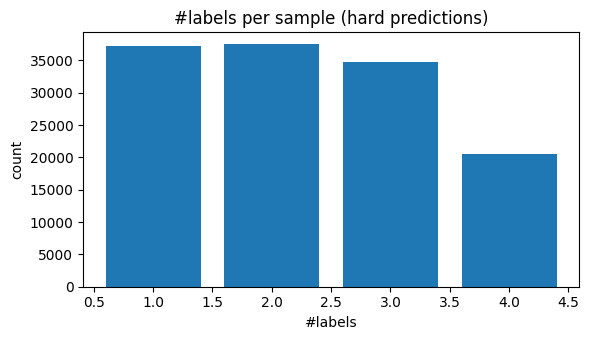

In [113]:
# 1.a) Per-label support (hard) and expected counts (sum of probs)
support_hard = Y_hat.sum(axis=0)
support_exp  = P.sum(axis=0)

label_stats = pd.DataFrame({
    "label": labels,
    "support_hard": support_hard,
    "support_expected": support_exp,
    "prevalence_%": 100*support_hard/len(df)
}).sort_values("support_hard", ascending=False)

print(label_stats)

# 1.b) Cardinality & density (how multi is your data?)
k_per_row = Y_hat.sum(axis=1)
cardinality = k_per_row.mean()
density = cardinality / len(labels)
print(f"\nCardinality (avg labels per sample): {cardinality:.3f}")
print(f"Density (cardinality / {len(labels)}): {density:.3f}")

# 1.c) Distribution of #labels per sample (hist)
counts = pd.Series(k_per_row).value_counts().sort_index()
plt.figure(figsize=(6,3.5))
plt.bar(counts.index.astype(int), counts.values)
plt.title("#labels per sample (hard predictions)")
plt.xlabel("#labels"); plt.ylabel("count"); plt.tight_layout(); plt.show()


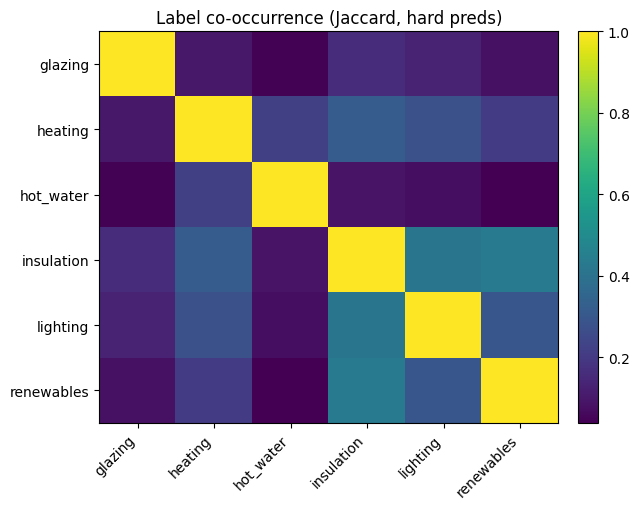

In [114]:
# 2.a) Hard co-occurrence matrix
C = Y_hat.T @ Y_hat  # (L x L)
cooc_df = pd.DataFrame(C, index=labels, columns=labels)

# 2.b) Normalize to Jaccard-like (optional): C_ij / (C_i + C_j - C_ij)
diag = np.diag(C).astype(float)
den = (diag[:,None] + diag[None,:] - C).clip(min=1e-9)
cooc_jacc = C / den
cooc_jacc_df = pd.DataFrame(cooc_jacc, index=labels, columns=labels)

# 2.c) Plot heatmap (matplotlib only)
fig, ax = plt.subplots(figsize=(6.5,5.2))
im = ax.imshow(cooc_jacc, aspect="auto")
ax.set_title("Label co-occurrence (Jaccard, hard preds)")
ax.set_xticks(range(len(labels))); ax.set_yticks(range(len(labels)))
ax.set_xticklabels(labels, rotation=45, ha="right"); ax.set_yticklabels(labels)
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.tight_layout(); plt.show()


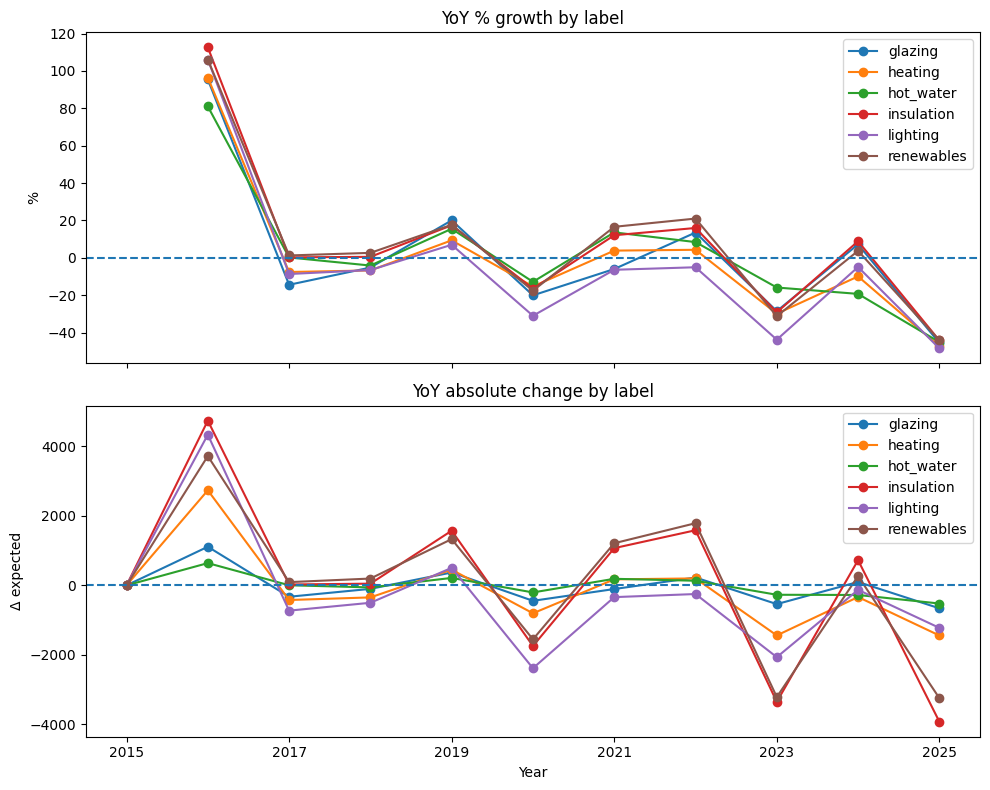

In [116]:
exp_by_year = (
    pd.DataFrame(P, columns=labels)
    .assign(year=df["year"].values)
    .groupby("year").sum().sort_index()
)


yoy_abs = exp_by_year.diff().fillna(0)
with np.errstate(divide='ignore', invalid='ignore'):
    yoy_pct = (exp_by_year.pct_change()*100).replace([np.inf, -np.inf], np.nan)

fig, axes = plt.subplots(2, 1, figsize=(10,8), sharex=True)
yoy_pct.plot(ax=axes[0], marker="o"); axes[0].axhline(0, ls="--")
axes[0].set_title("YoY % growth by label"); axes[0].set_ylabel("%")

yoy_abs.plot(ax=axes[1], marker="o"); axes[1].axhline(0, ls="--")
axes[1].set_title("YoY absolute change by label"); axes[1].set_ylabel("Δ expected"); axes[1].set_xlabel("Year")
plt.tight_layout(); plt.show()
